In [1]:
%%capture capt
!pip install scikit-learn==1.1.2
!pip install -U scikit-survival
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

## Test Example

In [3]:
from sksurv.datasets import load_gbsg2
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

/opt/mamba/lib/python3.10/site-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


In [6]:
Xt

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
0,70.0,66.0,0.0,1.0,3.0,48.0,21.0,1.0
1,56.0,77.0,1.0,1.0,7.0,61.0,12.0,1.0
2,58.0,271.0,1.0,1.0,9.0,52.0,35.0,1.0
3,59.0,29.0,1.0,1.0,4.0,60.0,17.0,1.0
4,73.0,65.0,0.0,1.0,1.0,26.0,35.0,1.0
...,...,...,...,...,...,...,...,...
681,49.0,84.0,0.0,0.0,3.0,1.0,30.0,2.0
682,53.0,0.0,1.0,1.0,17.0,0.0,25.0,2.0
683,51.0,0.0,0.0,0.0,5.0,43.0,25.0,2.0
684,52.0,34.0,0.0,1.0,3.0,15.0,23.0,1.0


In [106]:
y[0:3]

array([( True, 1814.), ( True, 2018.), ( True,  712.)],
      dtype=[('cens', '?'), ('time', '<f8')])

## Notre base

In [93]:
profil_patient=pd.read_csv("../data/profil_patient.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,0,23,1,1,1,0
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,0,51,2,1,1,1
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,1,43,0,1,1,2
3,P13,2011-05-19,1959,974,1,NaN,False,2783,2,0,3,0,1,0,3
4,P16,2010-03-18,1947,76,1,NaN,False,3210,9,0,28,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,P24302,2014-02-08,1920,29,1,2014-12,True,318,8,0,47,2,1,1,12
10047,P24303,2012-02-09,1927,61,1,2017-05,True,1924,12,0,86,2,2,2,6
10048,P24304,2010-07-27,1924,999,1,2010-08,True,5,1,0,10,2,0,1,13
10049,P24308,2011-11-25,1925,13,2,2013-03,True,484,7,0,99,2,1,2,1


In [100]:
data=profil_patient[['y_nais','BEN_SEX_COD','Nb_hospit','CHOC','Nb_jours_sej','cluster']]
Label= profil_patient[['Mort','Nb_survie']].to_records(index=False)
Label

True 456


In [109]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=random_state)

In [110]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state,
                           verbose=10)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [111]:
rsf.score(X_test, y_test)

0.6807206893779263

In [113]:
X_test_sorted = X_test.sort_values(by=['y_nais'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,y_nais,BEN_SEX_COD,Nb_hospit,CHOC,Nb_jours_sej,cluster
5471,1909,2,5,0,35,1
1275,1910,2,2,0,4,1
4626,1910,2,6,0,62,1
9775,1990,1,3,0,48,3
472,1991,1,19,0,67,5
6602,1994,2,62,1,135,15


In [114]:
pd.Series(rsf.predict(X_test_sel))

0    3160.879601
1    3315.282432
2    2463.374281
3    1158.473107
4     380.825466
5     454.293035
dtype: float64

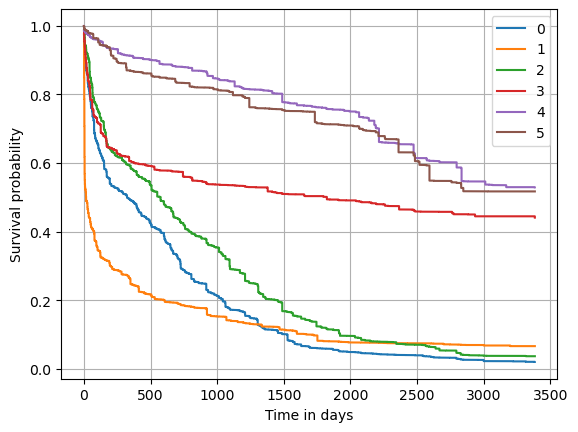

In [115]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

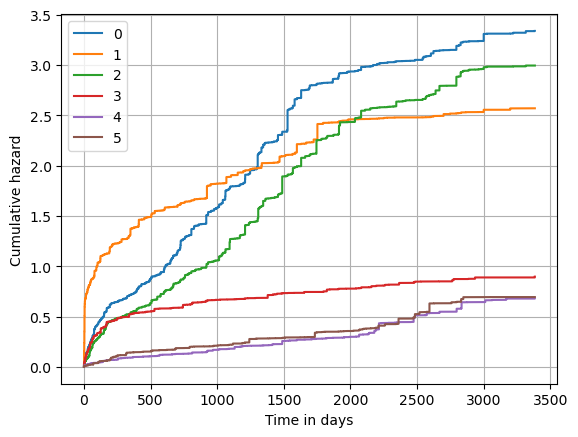

In [116]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [117]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

In [118]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
y_nais,0.076927,0.006315
Nb_hospit,0.070946,0.003016
Nb_jours_sej,0.034826,0.002130
cluster,0.008921,0.001933
CHOC,0.008184,0.001062
BEN_SEX_COD,-0.000037,0.000794


## Essai 2

In [143]:
data=profil_patient[['y_nais','BEN_SEX_COD','Nb_hospit','CHOC','Nb_jours_sej']]
Label= profil_patient[['Mort','Nb_survie']].to_records(index=False)
Label

rec.array([(False, 2596), ( True,  456), ( True,   41), ...,
           ( True,    5), ( True,  484), (False, 2935)],
          dtype=[('Mort', '?'), ('Nb_survie', '<i8')])

In [144]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=random_state)

In [ ]:
rsf = RandomSurvivalForest(n_estimators=500,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state,
                           verbose=5)
rsf.fit(X_train, y_train)

In [146]:
rsf.score(X_test, y_test)

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    1.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    1.7s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    2.1s finished


0.6808967082775095

In [147]:
X_test_sorted = X_test.sort_values(by=['y_nais'])
X_test_sel = pd.concat((X_test_sorted.head(5), X_test_sorted.tail(5)))

X_test_sel

,y_nais,BEN_SEX_COD,Nb_hospit,CHOC,Nb_jours_sej
5471,1909,2,5,0,35
1275,1910,2,2,0,4
4626,1910,2,6,0,62
6656,1911,2,3,0,21
7931,1911,2,1,0,3
2839,1989,1,11,0,31
4785,1990,2,69,0,534
9775,1990,1,3,0,48
472,1991,1,19,0,67
6602,1994,2,62,1,135


In [148]:
pd.Series(rsf.predict(X_test_sel))

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.3s finished


0    3337.484628
1    3442.453171
2    2418.257128
3    3633.403401
4    3710.089553
5     365.409662
6     389.915013
7    1217.103469
8     412.726880
9     502.934446
dtype: float64

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.4s finished


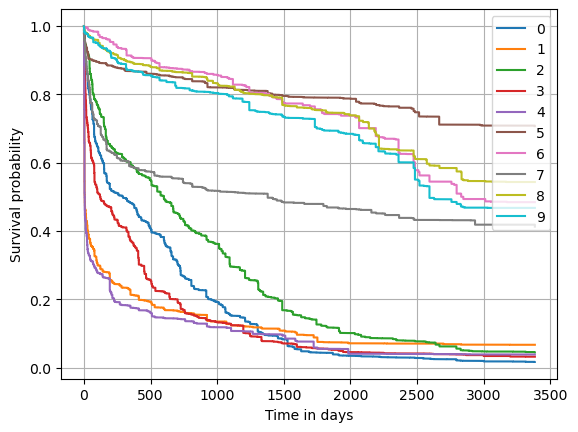

In [149]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=random_state)

In [151]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
y_nais,0.096716,0.005796
Nb_hospit,0.094094,0.003398
Nb_jours_sej,0.039792,0.001675
CHOC,0.010568,0.001184
BEN_SEX_COD,0.006734,0.000910


In [154]:
rsf.decision_path(X_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


(<7538x209934 sparse matrix of type '<class 'numpy.int64'>'
 	with 38995630 stored elements in Compressed Sparse Row format>,
 array([     0,    413,    784,   1241,   1662,   2061,   2508,   2977,
          3342,   3781,   4142,   4569,   4982,   5377,   5840,   6295,
          6726,   7137,   7562,   7995,   8442,   8871,   9296,   9731,
         10120,  10525,  10942,  11357,  11788,  12215,  12578,  13023,
         13386,  13849,  14310,  14735,  15186,  15609,  16008,  16421,
         16876,  17289,  17748,  18121,  18544,  18943,  19310,  19671,
         20048,  20417,  20722,  21115,  21524,  21931,  22310,  22719,
         23106,  23553,  23972,  24367,  24802,  25243,  25690,  26091,
         26562,  27001,  27438,  27821,  28202,  28635,  28998,  29317,
         29746,  30201,  30638,  30993,  31376,  31807,  32236,  32661,
         32990,  33411,  33820,  34213,  34610,  35029,  35502,  35965,
         36398,  36823,  37256,  37651,  38084,  38527,  38958,  39365,
         3

In [166]:
from sksurv.compare import compare_survival
print("Compares the pooled hazard rate with each group-specific hazard rate.")
print("The alternative hypothesis is that the hazard rate of at least one group differs from the others at some time.")
print("Valeur de la statistique | p-valeur")
compare_survival(Label[0:20], X_test[0:20], return_stats=False)

Compares the pooled hazard rate with each group-specific hazard rate.
The alternative hypothesis is that the hazard rate of at least one group differs from the others at some time.
Valeur de la statistique | p-valeur


(204.9744519431937, 1.280361921944441e-21)

## Gradient boosting

In [168]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
data=profil_patient[['y_nais','BEN_SEX_COD','Nb_hospit','CHOC','Nb_jours_sej']]
Label= profil_patient[['Mort','Nb_survie']].to_records(index=False)

In [169]:
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=random_state)

In [ ]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0, verbose=3)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

In [ ]:
scores_cph_tree = {}
est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0, verbose=3)
for i in range(1, 20,2):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

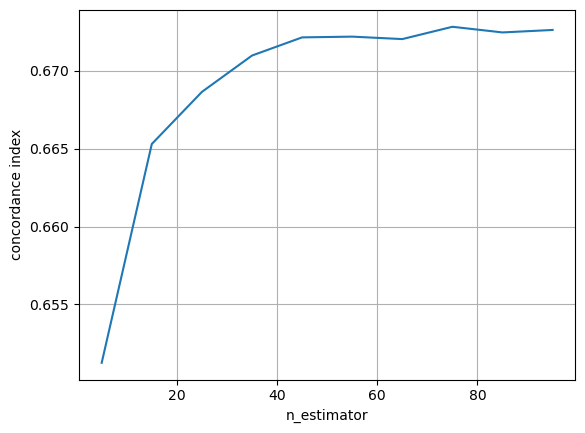

In [178]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0,verbose=3)
for i in range(1, 20,2):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

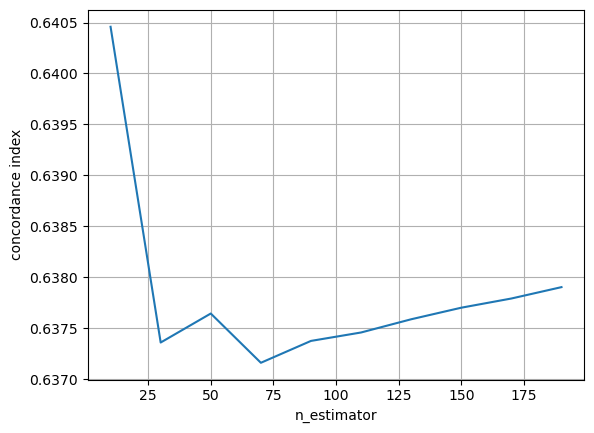

In [181]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [183]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + data.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 4


CHOC            0.388351
Nb_hospit      -0.061323
Nb_jours_sej    0.004844
y_nais         -0.000106
dtype: float64

In [ ]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

In [ ]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, max_depth=1, random_state=0,verbose=3),
    "learning rate": GradientBoostingSurvivalAnalysis(
        learning_rate=0.1, max_depth=1, random_state=0,verbose=3),
    "dropout": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0,verbose=3),
    "subsample": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0,verbose=3),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

In [ ]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

In [ ]:
class EarlyStoppingMonitor:

    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5,
    max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

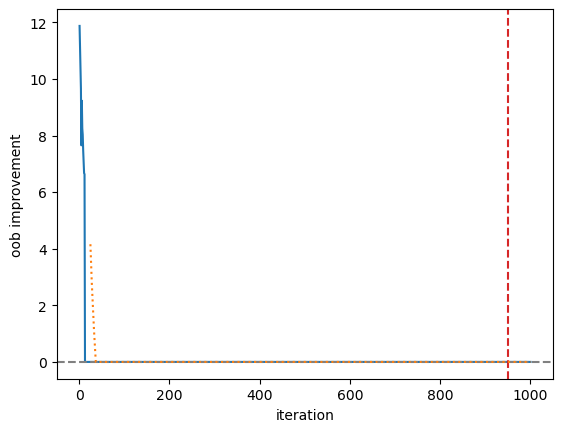

In [188]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_,
    index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

In [189]:
#https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html